In [1]:
!pip install sympy pyDOE

Looking in indexes: https://pypi.mirrors.ustc.edu.cn/simple/


In [2]:
#normal pinn 求解poisson

import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from torch.autograd import grad
from pyDOE import lhs
import random
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker
#import torch_optimizer as optim
#import seaborn as sns

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def setup_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cuda.matmul.allow_tf32 = False
        torch.backends.cudnn.allow_tf32 = False
        #torch.backends.cudnn.deterministic = True
        #torch.backends.cudnn.benchmark = False
    
setup_seed(666)



class ResBlock(nn.Module):
    def __init__(self, n_node):
        super(ResBlock, self).__init__()
        self.linear0 = torch.nn.Linear(n_node, n_node)
        self.linear1 = torch.nn.Linear(n_node, n_node)
        self.activation = torch.nn.GELU()
        nn.init.xavier_normal_(self.linear0.weight)
        nn.init.constant_(self.linear0.bias, 0)
        nn.init.xavier_normal_(self.linear1.weight)
        nn.init.constant_(self.linear1.bias, 0)
        #self.batchnorm = nn.BatchNorm1d(n_node)
        #self.batchnorm1 = nn.BatchNorm1d(n_node)
        

    def forward(self, x):
        out = self.linear0(x)                   
        #out = self.batchnorm(out)
        out = self.activation(out)
        #out = self.linear1(out)
        out = out+x                               #out = self.batchnorm(out)
        #out = self.activation(out)
        #return out + x
        return out
        
        
class ResBolck2L(torch.nn.Module):
    ''' ResBlock2L：
    net = ResBlock2L(dim_1,dim_2)
    net.forward: x+layers2(layers1(x))
    '''
    def __init__(self,dim_1,dim_2,act=None):
        super().__init__()
        self.layer_1 = torch.nn.Linear(dim_1,dim_2)
        self.layer_2 = torch.nn.Linear(dim_2,dim_1)
        self.act = torch.nn.functional.gelu if act == None else act
    
    def forward(self,x):
        return x + self.act(self.layer_2(self.act(self.layer_1(x))))        
        
        


class NetResDeep(nn.Module):
    def __init__(self, dim_in, dim_out, n_block, n_node,ub, lb):
        super().__init__()
        self.fc1 = nn.Linear(dim_in, n_node)
        self.activation = torch.nn.GELU()
        #self.resblocks = nn.Sequential(*[ResBolck2L(n_node,n_node) for _ in range(n_block)])
        self.resblocks = nn.Sequential(*[ResBlock(n_node) for _ in range(n_block)])
        self.fc2 = nn.Linear(n_node, dim_out)
        self.ub = torch.tensor(ub, dtype=torch.float).to(device)
        self.lb = torch.tensor(lb, dtype=torch.float).to(device)
        
    def forward(self, x):
        #out = (x - self.lb) / (self.ub - self.lb)  # Min-max scaling
        out = x
        out = self.fc1(out)
        #out = self.batchnorm(out)
        out=self.activation(out)
        out = self.resblocks(out)
        out = self.fc2(out)
        return out


def weights_init(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight.data)
        torch.nn.init.zeros_(m.bias.data)

def rhs(x):

    # Right-Hand-Side of the Poisson equation
        return 2*np.exp(alpha)*(np.pi**2)*torch.exp(np.pi*(x[:,0:1]+x[:,1:2]))\
            *((torch.sin(np.pi*(x[:,0:1]))*torch.cos(np.pi*(x[:,1:2])))\
              +(torch.cos(np.pi*(x[:,0:1]))*torch.sin(np.pi*(x[:,1:2]))))


# Parameters
# Parameters
x_min = 0
x_max = 1
y_min = 0
y_max = 1


ub = np.array([x_max, y_max])
lb = np.array([x_min, y_min])


N_bc = 300
N_f = 8000

########


x_points = lambda n: np.random.uniform(x_min, x_max, (n, 1))
y_points = lambda n: np.random.uniform(y_min, y_max, (n, 1))





# collocation points
'''
t_f = x_min + (t_max - t_min) * lhs(1, N_f)
x_f = y_min + (x_max - x_min) * lhs(1, N_f)
tx_f = np.hstack([t_f, x_f])
tx_f = np.vstack([tx_f, tx_bc])


xy_bc = torch.tensor(xy_bc, dtype=torch.float32).to(device)
u_bc = torch.tensor(u_bc, dtype=torch.float32).to(device)
xy_f = torch.tensor(xy_f, dtype=torch.float32).to(device)
#xy_f2 = torch.tensor(xy_f2, dtype=torch.float32).to(device)
'''

class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
    
    #def __init__(self) -> None:
        self.net=NetResDeep( dim_in=2, dim_out=1, n_block=3, n_node=60, ub=ub, lb=lb).to(device)
        #self.net = DNN(dim_in=2, dim_out=1, n_layer=6, n_node=100, ub=ub, lb=lb).to(device)
        self.iter = 0
        self.optimizer = torch.optim.LBFGS(
            self.net.parameters(),
            lr=1,
            max_iter=50000,
            max_eval=50000,
            history_size=200,
            tolerance_grad=1e-12, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe",
        )#tolerance_change=1.0 * np.finfo(float).eps,
        self.adam = torch.optim.Adam(self.net.parameters(), lr=2e-3)
        #self.Yogi = optim.Yogi(self.net.parameters(), lr=1e-4)
        #self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.adam, T_max = 500)
        #self.scheduler=torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(self.adam,T_0=200,T_mult=2,eta_min=1e-9)
        self.scheduler=torch.optim.lr_scheduler.StepLR(self.adam,step_size=30,gamma=0.99)
        self.losses = {"loss": [], "bc": [], "pde": []}
        #self.kk=500000
    
    def loss_bc(self, xyt):
        u = self.net(xyt)
        #u=torch.exp(alpha+np.pi*(xyt[:,0:1]+xyt[:,1:2]))*torch.sin(np.pi*xyt[:,0:1])*torch.sin(np.pi*xyt[:,1:2])
        mse_bc = torch.mean(torch.square(u - u_bc))
        return mse_bc

    def loss_pde(self, xyt):
        xy = xyt.clone()
        xy.requires_grad = True

        u = self.net(xy)
        #u=torch.exp(alpha+np.pi*(xy[:,0:1]+xy[:,1:2]))*torch.sin(np.pi*xy[:,0:1])*torch.sin(np.pi*xy[:,1:2])
        u_xyt = grad(u.sum(), xy, create_graph=True)[0]
        u_xx = grad(u_xyt[:, 0:1].sum(), xy, create_graph=True)[0][:, 0:1]
        u_yy = grad(u_xyt[:, 1:2].sum(), xy, create_graph=True)[0][:, 1:2]
        #Q=rhs(xy)
        pde =-rhs(xy)+u_xx + u_yy
        
        #pde = (-rhs(xy)+u_xx + u_yy)/rhs(xy)
        mse_pde = torch.mean(torch.square(pde))
        return mse_pde

    def closure(self):
        self.optimizer.zero_grad()
        self.adam.zero_grad()
        #self.Yogi.zero_grad()
        mse_bc = self.loss_bc(xy_bc)
        mse_pde = self.loss_pde(xy_f)
        

        loss = mse_bc + mse_pde
        
        
        loss.backward()
        
        self.losses["loss"]=loss.detach().cpu().item()
        self.losses["bc"]=mse_bc.detach().cpu().item()
        self.losses["pde"]=mse_pde.detach().cpu().item()
        
        
        self.iter += 1
        if self.iter % 500 == 0:
            
            print(f"{self.iter} Loss: {loss.item():.5e}  BC: {mse_bc.item():.5e} pde:{mse_pde.item():.5e}")
        return loss


    
    

for alpha in [6]: 
    
    pinn = PINN()
    
    
    
    
    x_bc1 = np.ones((N_bc, 1))*x_min
    y_bc1 = y_points(N_bc)
    u_bc1 = np.zeros((N_bc, 1))


    x_bc2 = np.ones((N_bc, 1)) * x_max
    y_bc2 = y_points(N_bc)
    u_bc2 = np.zeros((N_bc, 1))

    x_bc3 = x_points(N_bc)
    y_bc3 = np.ones((N_bc, 1))*y_min
    u_bc3 = np.zeros((N_bc, 1))

    x_bc4 = x_points(N_bc)
    y_bc4 = np.ones((N_bc, 1)) * y_max
    u_bc4 = np.zeros((N_bc, 1))

    x_bc = np.vstack([x_bc1, x_bc2, x_bc3, x_bc4])
    y_bc = np.vstack([y_bc1, y_bc2, y_bc3, y_bc4])
    xy_bc = np.hstack([x_bc, y_bc])
    u_bc = np.vstack([u_bc1, u_bc2, u_bc3, u_bc4])


   # collocation points
    x_f = x_min + (x_max - x_min) * lhs(1, N_f)
    y_f = y_min + (y_max - y_min) * lhs(1, N_f)
    xy_f = np.hstack([x_f, y_f])
    xy_f = np.vstack([xy_f, xy_bc])


    xy_bc = torch.tensor(xy_bc, dtype=torch.float32).to(device)
    u_bc = torch.tensor(u_bc, dtype=torch.float32).to(device)
    xy_f = torch.tensor(xy_f, dtype=torch.float32).to(device)
    
    
    for i in range(5000):
        pinn.closure()
        pinn.adam.step()
        pinn.scheduler.step()
    #pinn.optimizer.step(pinn.closure)
    
    print(f"{pinn.iter} Loss: {pinn.losses['loss']:.5e}  BC: {pinn.losses['bc']:.5e} pde: {pinn.losses['pde']:.5e}")
    
    #torch.save(pinn.state_dict(), 'poisson-normal.pt') 
    
    
    
    

/root/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


500 Loss: 9.79754e+10  BC: 3.85924e+06 pde:9.79715e+10
1000 Loss: 2.34875e+10  BC: 2.88993e+07 pde:2.34586e+10
1500 Loss: 1.51309e+10  BC: 4.58226e+07 pde:1.50851e+10
2000 Loss: 1.03430e+10  BC: 5.74964e+07 pde:1.02855e+10
2500 Loss: 8.54035e+09  BC: 6.76031e+07 pde:8.47275e+09
3000 Loss: 7.33826e+09  BC: 7.72426e+07 pde:7.26102e+09
3500 Loss: 6.48405e+09  BC: 8.65699e+07 pde:6.39748e+09
4000 Loss: 5.70792e+09  BC: 9.52602e+07 pde:5.61266e+09
4500 Loss: 5.09880e+09  BC: 1.03815e+08 pde:4.99498e+09
5000 Loss: 4.59811e+09  BC: 1.11943e+08 pde:4.48617e+09
5000 Loss: 4.59811e+09  BC: 1.11943e+08 pde: 4.48617e+09


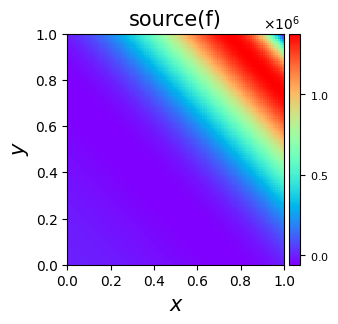

In [3]:
X0,Y0 = np.meshgrid(np.linspace(0,1,101),np.linspace(0,1,101))
Z0 = 2*np.exp(alpha)*(np.pi**2)*np.exp(np.pi*(X0+Y0))*(np.sin(np.pi*(X0))*np.cos(np.pi*(Y0))+(np.cos(np.pi*(X0))*np.sin(np.pi*(Y0))))
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111)
hh = ax.imshow(-Z0, interpolation='nearest', cmap='rainbow', 
            extent=[0, 1, 0, 1], 
            origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
#fig.colorbar(h, cax=cax)
cbar = fig.colorbar(hh, cax=cax)
cbar.ax.tick_params(labelsize=8)  
tick_locator = ticker.MaxNLocator(nbins=3)  # colorbar上的刻度值个数
cbar.locator = tick_locator
#ax.plot(x_bc, y_bc, 'kx', markersize = 4, clip_on = False)
ax.set_title('source(f)',fontsize=15)
ax.set_xlabel('x', fontsize=15,fontfamily = 'sans-serif',fontstyle='italic')
ax.set_ylabel('y', fontsize=15,fontstyle='oblique')
plt.gca().ticklabel_format(style='scientific',scilimits=(-2,2),useMathText=True)

#plt.savefig('./pic/sour_4.pdf', format='pdf', bbox_inches='tight') 

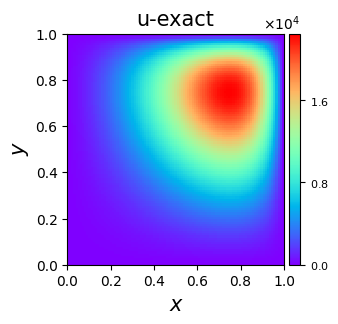

In [4]:
X0,Y0 = np.meshgrid(np.linspace(0,1,101),np.linspace(0,1,101))
Z0 = np.exp(alpha+np.pi*(X0+Y0))*np.sin(np.pi*X0)*np.sin(np.pi*Y0)
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111)
hh = ax.imshow(Z0, interpolation='nearest', cmap='rainbow', 
            extent=[0, 1, 0, 1], 
            origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(hh, cax=cax)
cbar.ax.tick_params(labelsize=8) 
tick_locator = ticker.MaxNLocator(nbins=3)  # colorbar上的刻度值个数
cbar.locator = tick_locator
ax.set_title('u-exact',fontsize=15)
ax.set_xlabel('x', fontsize=15,fontfamily = 'sans-serif',fontstyle='italic')
ax.set_ylabel('y', fontsize=15,fontstyle='oblique')
plt.gca().ticklabel_format(style='scientific',scilimits=(-2,2),useMathText=True)
#plt.savefig('./img0_n/real-{}.png'.format(alpha),bbox_inches='tight')
#plt.close()

#plt.savefig('./pic/2-real.pdf', format='pdf', bbox_inches='tight') 

Text(0, 0.5, 'y')

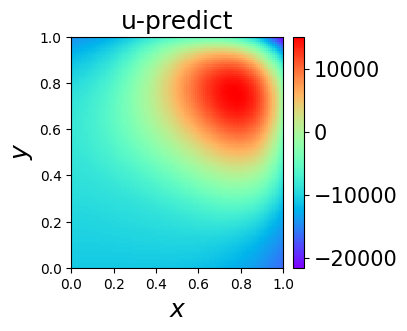

In [5]:
#X0,Y0 = np.meshgrid(np.linspace(0,1,101),np.linspace(0,1,101))
tX,tY = torch.tensor(X0,dtype=torch.float32,device=device),torch.tensor(Y0,dtype=torch.float32,device=device)
with torch.inference_mode(1):tZ = pinn.net(torch.cat([tX.reshape(-1,1),tY.reshape(-1,1)],dim=1)).reshape(101,101)
U0 = tZ.cpu().numpy()
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111)
h = ax.imshow(U0, interpolation='nearest', cmap='rainbow', 
              extent=[0, 1, 0, 1], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 
ax.set_title('u-predict',fontsize=18)
ax.set_xlabel('x', fontsize=18,fontfamily = 'sans-serif',fontstyle='italic')
ax.set_ylabel('y', fontsize=18,fontstyle='oblique')
#plt.savefig('./img0_n/predict-{}.png'.format(alpha),bbox_inches='tight')
#plt.close()
    
#plt.savefig('./pic/2-real.pdf', format='pdf', bbox_inches='tight') 
    

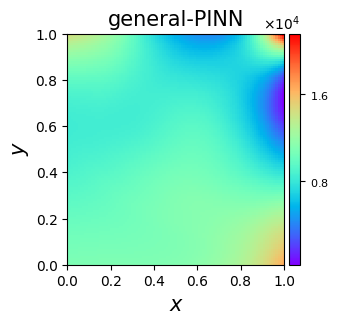

In [6]:
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111)
h = ax.imshow(abs(Z0-U0), interpolation='nearest', cmap='rainbow', 
              extent=[0, 1, 0, 1], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=8) 
tick_locator = ticker.MaxNLocator(nbins=3)  # colorbar上的刻度值个数
cbar.locator = tick_locator 
ax.set_title('general-PINN' ,fontsize=15)
ax.set_xlabel('x', fontsize=15,fontfamily = 'sans-serif',fontstyle='italic')
ax.set_ylabel('y', fontsize=15,fontstyle='oblique')
plt.gca().ticklabel_format(style='scientific',scilimits=(-2,2),useMathText=True)
    

plt.savefig('./pic/2_err_normal.pdf', format='pdf', bbox_inches='tight') 

In [7]:
err=torch.from_numpy(Z0-U0)
u_norm=torch.from_numpy(U0)
error_vec_1 = torch.linalg.vector_norm(err,float('inf')).numpy()
error_vec_2 = (torch.linalg.vector_norm(err,2)/torch.linalg.vector_norm(u_norm,2)).numpy()
error_vec_3 = (torch.linalg.vector_norm(err,1).numpy())/err.numel()
print(f"L_2 error: {error_vec_2:.3e}")
print(f"L_inf error: {error_vec_1:.3e}")
print(f"L_1 error: {error_vec_3:.3e}")

L_2 error: 1.168e+00
L_inf error: 2.158e+04
L_1 error: 9.384e+03
